In [1]:
import numpy as np
import itertools
import json

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration, _sigmoid_calibration
from ampligraph.evaluation import evaluate_performance, mr_score, mrr_score, hits_at_n_score, generate_corruptions_for_eval
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from scipy.special import expit

from ampligraph.datasets import load_wn11
from ampligraph.latent_features.models import TransE, ComplEx, DistMult

In [2]:
from generate_corruptions import generate_corruptions, calibration_loss, pos_iso
import types

In [3]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [4]:
X = load_wn11()

In [5]:
X_valid_pos = X['valid'][X['valid_labels']]
X_valid_neg = X['valid'][~X['valid_labels']]

X_test_pos = X['test'][X['test_labels']]
X_test_neg = X['test'][~X['test_labels']]

In [6]:
results = []

for eta in [1, 5, 10, 20, 50, 100]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=100, eta=eta,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'eta': eta,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 1,
  "brier_score_scores": 0.41342416273867294,
  "log_loss_scores": 1.779899321734355,
  "brier_score_probas_pos": 0.09541068967943639,
  "log_loss_probas_pos": 0.33895457905773574,
  "brier_score_probas_pos_neg": 0.0949087171153033,
  "log_loss_probas_pos_neg": 0.3381769867329649,
  "brier_score_probas_pos_neg_iso": 0.08996124820402579,
  "log_loss_probas_pos_neg_iso": 0.3067755307268407,
  "brier_score_probas_pos_iso": 0.09013523493363781,
  "log_loss_probas_pos_iso": 0.30829609171038774,
  "brier_score_probas_pos_sc": 0.09574791756063782,
  "log_loss_probas_pos_sc": 0.34024632256255477,
  "brier_score_probas_pos_neg_sc": 0.09510965827795079,
  "log_loss_probas_pos_neg_sc": 0.3383694541873895,
  "ece_scores": 0.44735216477383555,
  "ece_probas_pos": 0.06411032723640048,
  "ece_probas_pos_neg": 0.06018350582418983,
  "ece_probas_pos_neg_iso": 0.0069999937880055535,
  "ece_probas_pos_iso": 0.014389912815352577,
  "ece_probas_pos_sc": 0.0667867720359698,
  "ece_probas_pos_ne

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 5,
  "brier_score_scores": 0.43699314154103647,
  "log_loss_scores": 1.9264207942811407,
  "brier_score_probas_pos": 0.09283400627072487,
  "log_loss_probas_pos": 0.31487831818897,
  "brier_score_probas_pos_neg": 0.09124270977453644,
  "log_loss_probas_pos_neg": 0.3102425677465335,
  "brier_score_probas_pos_neg_iso": 0.08910547857917997,
  "log_loss_probas_pos_neg_iso": 0.299454113010115,
  "brier_score_probas_pos_iso": 0.08912877595904815,
  "log_loss_probas_pos_iso": 0.3004867061734526,
  "brier_score_probas_pos_sc": 0.09199126377238398,
  "log_loss_probas_pos_sc": 0.3125856185670163,
  "brier_score_probas_pos_neg_sc": 0.09136165416816251,
  "log_loss_probas_pos_neg_sc": 0.3103477620346627,
  "ece_scores": 0.46161586069811494,
  "ece_probas_pos": 0.05156502103752306,
  "ece_probas_pos_neg": 0.03935560719877115,
  "ece_probas_pos_neg_iso": 0.012288010490321946,
  "ece_probas_pos_iso": 0.01799301231764499,
  "ece_probas_pos_sc": 0.046642922593842104,
  "ece_probas_pos_neg_sc

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 10,
  "brier_score_scores": 0.44287973503067574,
  "log_loss_scores": 1.9626501455827219,
  "brier_score_probas_pos": 0.094510038070009,
  "log_loss_probas_pos": 0.31897515706014323,
  "brier_score_probas_pos_neg": 0.09266024906415381,
  "log_loss_probas_pos_neg": 0.31340263152223796,
  "brier_score_probas_pos_neg_iso": 0.09055467711182483,
  "log_loss_probas_pos_neg_iso": 0.30316607565237,
  "brier_score_probas_pos_iso": 0.09051444309653682,
  "log_loss_probas_pos_iso": 0.3038983265200303,
  "brier_score_probas_pos_sc": 0.09336691687480572,
  "log_loss_probas_pos_sc": 0.31568751612346185,
  "brier_score_probas_pos_neg_sc": 0.09278405939084342,
  "log_loss_probas_pos_neg_sc": 0.3134967238706228,
  "ece_scores": 0.4650514822955738,
  "ece_probas_pos": 0.054175367309855275,
  "ece_probas_pos_neg": 0.04009183564065592,
  "ece_probas_pos_neg_iso": 0.008156941914531804,
  "ece_probas_pos_iso": 0.01750515645390469,
  "ece_probas_pos_sc": 0.04630326795168721,
  "ece_probas_pos_neg_

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 20,
  "brier_score_scores": 0.44648916226759366,
  "log_loss_scores": 1.9816307518702798,
  "brier_score_probas_pos": 0.0960492270472998,
  "log_loss_probas_pos": 0.32290966516851694,
  "brier_score_probas_pos_neg": 0.09404467443035396,
  "log_loss_probas_pos_neg": 0.31672234923526077,
  "brier_score_probas_pos_neg_iso": 0.09177538105139223,
  "log_loss_probas_pos_neg_iso": 0.30629326715333577,
  "brier_score_probas_pos_iso": 0.09206256230332957,
  "log_loss_probas_pos_iso": 0.30783374822920995,
  "brier_score_probas_pos_sc": 0.09470749683912831,
  "log_loss_probas_pos_sc": 0.31895324748735704,
  "brier_score_probas_pos_neg_sc": 0.09417338923581584,
  "log_loss_probas_pos_neg_sc": 0.3168093009286027,
  "ece_scores": 0.46713653361387186,
  "ece_probas_pos": 0.05598063397792271,
  "ece_probas_pos_neg": 0.039924394705689245,
  "ece_probas_pos_neg_iso": 0.008923501891360472,
  "ece_probas_pos_iso": 0.017923076649194007,
  "ece_probas_pos_sc": 0.04588236383170484,
  "ece_probas_p

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "eta": 50,
  "brier_score_scores": 0.44886699119307716,
  "log_loss_scores": 1.990491859725458,
  "brier_score_probas_pos": 0.09728507035210128,
  "log_loss_probas_pos": 0.32592966771749315,
  "brier_score_probas_pos_neg": 0.09521018229213665,
  "log_loss_probas_pos_neg": 0.31933020204049745,
  "brier_score_probas_pos_neg_iso": 0.0930383970277979,
  "log_loss_probas_pos_neg_iso": 0.30964178447544816,
  "brier_score_probas_pos_iso": 0.09334438352861352,
  "log_loss_probas_pos_iso": 0.3107714677266886,
  "brier_score_probas_pos_sc": 0.09583706743478762,
  "log_loss_probas_pos_sc": 0.32157475249365913,
  "brier_score_probas_pos_neg_sc": 0.09534365155426393,
  "log_loss_probas_pos_neg_sc": 0.31941550581214145,
  "ece_scores": 0.4684930624701003,
  "ece_probas_pos": 0.055138951399042464,
  "ece_probas_pos_neg": 0.04121196208285231,
  "ece_probas_pos_neg_iso": 0.007970334137198989,
  "ece_probas_pos_iso": 0.01603492261413422,
  "ece_probas_pos_sc": 0.046415303831083485,
  "ece_probas_pos

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [7]:
eta_results = results

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df=pd.DataFrame(eta_results)
df.columns

Index(['accuracy_per_relation', 'accuracy_pos', 'accuracy_pos_iso',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_neg_sc',
       'accuracy_pos_sc', 'accuracy_uncalib', 'brier_score_probas_pos',
       'brier_score_probas_pos_iso', 'brier_score_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'brier_score_probas_pos_neg_sc',
       'brier_score_probas_pos_sc', 'brier_score_scores', 'ece_probas_pos',
       'ece_probas_pos_iso', 'ece_probas_pos_neg', 'ece_probas_pos_neg_iso',
       'ece_probas_pos_neg_sc', 'ece_probas_pos_sc', 'ece_scores', 'eta',
       'log_loss_probas_pos', 'log_loss_probas_pos_iso',
       'log_loss_probas_pos_neg', 'log_loss_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_sc', 'log_loss_probas_pos_sc',
       'log_loss_scores', 'metrics_hits@10', 'metrics_mr', 'metrics_mrr'],
      dtype='object')

In [10]:
df.to_csv("wn11_eta.csv", index=False)

Text(0.5, 1.0, 'WN11')

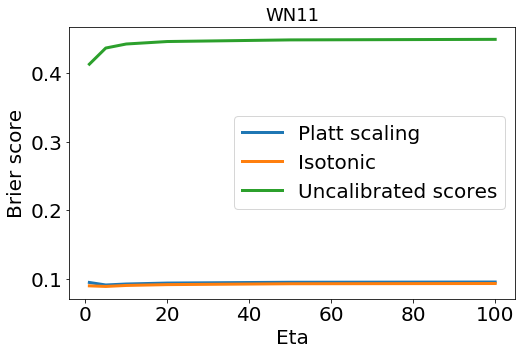

In [11]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 20, 'axes.titlesize': 18})
plt.plot(df.eta, df.brier_score_probas_pos_neg, lw=3, label="Platt scaling")
plt.plot(df.eta, df.brier_score_probas_pos_neg_iso, lw=3, label="Isotonic")
plt.plot(df.eta, df.brier_score_scores, lw=3, label="Uncalibrated scores")
plt.xlabel("Eta")
plt.ylabel("Brier score")
plt.legend()
plt.title("WN11")

In [12]:
results = []

for k in [10, 25, 50, 100, 200, 500]:
    model = TransE(batches_count=64, seed=0, epochs=500, k=k, eta=20,
                   optimizer='adam', optimizer_params={'lr':0.0001},
                   loss='self_adversarial', verbose=False)

    model.fit(X['train'])
    
    scores = model.predict(X['test'])

    model.calibrate(X_valid_pos, batches_count=10, epochs=1000, positive_base_rate=0.5)
    print("pos", model.calibration_parameters)
    probas1 = model.predict_proba(X['test'])

    model.calibrate(X_valid_pos, X_valid_neg)
    print("pos neg", model.calibration_parameters)
    probas2 = model.predict_proba(X['test'])
    
    val_scores = model.predict(X['valid'])
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels']).astype(float))
    probas3 = ir.predict(np.squeeze(scores).astype(float))
    
    model.generate_corruptions = types.MethodType(generate_corruptions, model)
    corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
    val_pos_scores = np.squeeze(model.predict(X_valid_pos))
    iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
    probas4 = iso_pos.predict(np.squeeze(scores).astype(float))

    sc_pos = pos_iso(_SigmoidCalibration(), val_pos_scores, corruptions, positive_base_rate=0.5)
    print("pos sc", sc_pos.a_, sc_pos.b_)
    probas5 = sc_pos.predict(np.squeeze(scores).astype(float))
    
    val_neg_scores = np.squeeze(model.predict(X_valid_neg))
    sc_pos_neg = pos_iso(_SigmoidCalibration(), val_pos_scores, val_neg_scores, positive_base_rate=0.5)
    print("pos neg sc", sc_pos_neg.a_, sc_pos_neg.b_)
    probas6 = sc_pos_neg.predict(np.squeeze(scores).astype(float))
    
    thresholds = {r: np.median(np.sort(val_scores[X['valid'][:, 1] == r])) for r in np.unique(X['valid'][:, 1])}
    thresholds_test = np.vectorize(thresholds.get)(X['test'][:, 1])
    per_relation_acc = accuracy_score(X['test_labels'], scores > thresholds_test)

    acc_uncalib = accuracy_score(X['test_labels'], expit(scores) > 0.5)
    
    acc1 = accuracy_score(X['test_labels'], probas1 > 0.5)
    acc2 = accuracy_score(X['test_labels'], probas2 > 0.5)
    acc3 = accuracy_score(X['test_labels'], probas3 > 0.5)
    acc4 = accuracy_score(X['test_labels'], probas4 > 0.5)
    acc5 = accuracy_score(X['test_labels'], probas5 > 0.5)
    acc6 = accuracy_score(X['test_labels'], probas6 > 0.5)
    
    filter_triples = np.concatenate((X['train'], X_valid_pos, X_test_pos))
    ranks = evaluate_performance(X_test_pos, 
                                 model=model, 
                                 filter_triples=filter_triples,
                                 use_default_protocol=True, 
                                 verbose=False)

    results.append({
        'k': k,
        'brier_score_scores': brier_score_loss(X['test_labels'], expit(scores)),
        'log_loss_scores': log_loss(X['test_labels'], expit(scores), eps=1e-7),
        'brier_score_probas_pos': brier_score_loss(X['test_labels'], probas1),
        'log_loss_probas_pos': log_loss(X['test_labels'], probas1, eps=1e-7),
        'brier_score_probas_pos_neg': brier_score_loss(X['test_labels'], probas2),
        'log_loss_probas_pos_neg': log_loss(X['test_labels'], probas2, eps=1e-7),
        'brier_score_probas_pos_neg_iso': brier_score_loss(X['test_labels'], probas3),
        'log_loss_probas_pos_neg_iso': log_loss(X['test_labels'], probas3, eps=1e-7),
        'brier_score_probas_pos_iso': brier_score_loss(X['test_labels'], probas4),
        'log_loss_probas_pos_iso': log_loss(X['test_labels'], probas4, eps=1e-7),
        'brier_score_probas_pos_sc': brier_score_loss(X['test_labels'], probas5),
        'log_loss_probas_pos_sc': log_loss(X['test_labels'], probas5, eps=1e-7),
        'brier_score_probas_pos_neg_sc': brier_score_loss(X['test_labels'], probas6),
        'log_loss_probas_pos_neg_sc': log_loss(X['test_labels'], probas6, eps=1e-7),
        'ece_scores': calibration_loss(X['test_labels'], expit(scores)),
        'ece_probas_pos': calibration_loss(X['test_labels'], probas1),
        'ece_probas_pos_neg': calibration_loss(X['test_labels'], probas2),
        'ece_probas_pos_neg_iso': calibration_loss(X['test_labels'], probas3),
        'ece_probas_pos_iso': calibration_loss(X['test_labels'], probas4),
        'ece_probas_pos_sc': calibration_loss(X['test_labels'], probas5),
        'ece_probas_pos_neg_sc': calibration_loss(X['test_labels'], probas6),
        'metrics_mrr': mrr_score(ranks), 
        'metrics_hits@10': hits_at_n_score(ranks, n=10),
        'metrics_mr': mr_score(ranks),
        'accuracy_per_relation': per_relation_acc,
        'accuracy_uncalib': acc_uncalib,
        'accuracy_pos': acc1,
        'accuracy_pos_neg': acc2,
        'accuracy_pos_neg_iso': acc3,
        'accuracy_pos_iso': acc4,
        'accuracy_pos_sc': acc5,
        'accuracy_pos_neg_sc': acc6
    })
        
    print(json.dumps(results[-1], indent=2))

pos [-0.8837755, -3.2558105]
pos neg [-0.8462018, -3.0886655]
pos sc -0.9513674669756281 -3.5172432931650066
pos neg sc -0.8455287868167236 -3.1104358523230116


/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/Am

{
  "k": 10,
  "brier_score_scores": 0.45117901860300624,
  "log_loss_scores": 1.693128625397921,
  "brier_score_probas_pos": 0.21653434846579084,
  "log_loss_probas_pos": 0.6213018606802483,
  "brier_score_probas_pos_neg": 0.21632819769423822,
  "log_loss_probas_pos_neg": 0.6209247206962728,
  "brier_score_probas_pos_neg_iso": 0.2138791596044595,
  "log_loss_probas_pos_neg_iso": 0.6173883861612018,
  "brier_score_probas_pos_iso": 0.2152978512322455,
  "log_loss_probas_pos_iso": 0.6188092725492461,
  "brier_score_probas_pos_sc": 0.21711275779257524,
  "log_loss_probas_pos_sc": 0.6227530489274143,
  "brier_score_probas_pos_neg_sc": 0.21633527620187584,
  "log_loss_probas_pos_neg_sc": 0.6208346034550999,
  "ece_scores": 0.45856630582788516,
  "ece_probas_pos": 0.04806095417061517,
  "ece_probas_pos_neg": 0.04478339506238536,
  "ece_probas_pos_neg_iso": 0.012278974235721878,
  "ece_probas_pos_iso": 0.0386410240254767,
  "ece_probas_pos_sc": 0.048697776811857864,
  "ece_probas_pos_neg_sc":

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 25,
  "brier_score_scores": 0.4569627089300749,
  "log_loss_scores": 2.0481298086675648,
  "brier_score_probas_pos": 0.14804577452639442,
  "log_loss_probas_pos": 0.4611395114246249,
  "brier_score_probas_pos_neg": 0.14783871387678624,
  "log_loss_probas_pos_neg": 0.46124870552045744,
  "brier_score_probas_pos_neg_iso": 0.14412363339658238,
  "log_loss_probas_pos_neg_iso": 0.4446558948633864,
  "brier_score_probas_pos_iso": 0.14425816533596025,
  "log_loss_probas_pos_iso": 0.4442990868511341,
  "brier_score_probas_pos_sc": 0.1477943396927218,
  "log_loss_probas_pos_sc": 0.4612075625168423,
  "brier_score_probas_pos_neg_sc": 0.1480451813084465,
  "log_loss_probas_pos_neg_sc": 0.46120094632535774,
  "ece_scores": 0.4719235121229875,
  "ece_probas_pos": 0.05728389028001168,
  "ece_probas_pos_neg": 0.05606331607962238,
  "ece_probas_pos_neg_iso": 0.007528490137634446,
  "ece_probas_pos_iso": 0.011291767685469722,
  "ece_probas_pos_sc": 0.055762471674923327,
  "ece_probas_pos_neg_s

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 50,
  "brier_score_scores": 0.45237240264542383,
  "log_loss_scores": 2.032728736238641,
  "brier_score_probas_pos": 0.11091871747170505,
  "log_loss_probas_pos": 0.3629953989546405,
  "brier_score_probas_pos_neg": 0.10988822294959773,
  "log_loss_probas_pos_neg": 0.3603251241714508,
  "brier_score_probas_pos_neg_iso": 0.10731742277138089,
  "log_loss_probas_pos_neg_iso": 0.3516080334846069,
  "brier_score_probas_pos_iso": 0.10732265400479027,
  "log_loss_probas_pos_iso": 0.3508320120284528,
  "brier_score_probas_pos_sc": 0.11018195335236718,
  "log_loss_probas_pos_sc": 0.3615620086134881,
  "brier_score_probas_pos_neg_sc": 0.11007612210762352,
  "log_loss_probas_pos_neg_sc": 0.3604162640097267,
  "ece_scores": 0.4702948510531882,
  "ece_probas_pos": 0.05466801186424819,
  "ece_probas_pos_neg": 0.04770762610892819,
  "ece_probas_pos_neg_iso": 0.012940586906341544,
  "ece_probas_pos_iso": 0.01706097465123009,
  "ece_probas_pos_sc": 0.04975164514970201,
  "ece_probas_pos_neg_sc"

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 100,
  "brier_score_scores": 0.44649295784200693,
  "log_loss_scores": 1.981591792968416,
  "brier_score_probas_pos": 0.09607207093700659,
  "log_loss_probas_pos": 0.32297920364370186,
  "brier_score_probas_pos_neg": 0.09407719337058379,
  "log_loss_probas_pos_neg": 0.3168167794567338,
  "brier_score_probas_pos_neg_iso": 0.09174102284655848,
  "log_loss_probas_pos_neg_iso": 0.30606474335930334,
  "brier_score_probas_pos_iso": 0.09199420538734196,
  "log_loss_probas_pos_iso": 0.30766309384064017,
  "brier_score_probas_pos_sc": 0.0947294688257738,
  "log_loss_probas_pos_sc": 0.3190233444946032,
  "brier_score_probas_pos_neg_sc": 0.0942063928398588,
  "log_loss_probas_pos_neg_sc": 0.3169039942683341,
  "ece_scores": 0.46713854239868485,
  "ece_probas_pos": 0.05598548355652305,
  "ece_probas_pos_neg": 0.040005667541373816,
  "ece_probas_pos_neg_iso": 0.009297120864252361,
  "ece_probas_pos_iso": 0.01587806465012566,
  "ece_probas_pos_sc": 0.04544460509000817,
  "ece_probas_pos_neg

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in double_scalars
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


{
  "k": 200,
  "brier_score_scores": 0.4434155254696588,
  "log_loss_scores": 1.9473925456550734,
  "brier_score_probas_pos": 0.08917570878668649,
  "log_loss_probas_pos": 0.30245898001182353,
  "brier_score_probas_pos_neg": 0.08697098820337651,
  "log_loss_probas_pos_neg": 0.2945033566435511,
  "brier_score_probas_pos_neg_iso": 0.08550379719432986,
  "log_loss_probas_pos_neg_iso": 0.2894321489232178,
  "brier_score_probas_pos_iso": 0.08565831792939088,
  "log_loss_probas_pos_iso": 0.28947356360530707,
  "brier_score_probas_pos_sc": 0.08771940121479557,
  "log_loss_probas_pos_sc": 0.29723397911726324,
  "brier_score_probas_pos_neg_sc": 0.08707570819270306,
  "log_loss_probas_pos_neg_sc": 0.29461844874224496,
  "ece_scores": 0.4654526035882223,
  "ece_probas_pos": 0.04831930873092266,
  "ece_probas_pos_neg": 0.032459899784646806,
  "ece_probas_pos_neg_iso": 0.006651745328520246,
  "ece_probas_pos_iso": 0.01653706249336348,
  "ece_probas_pos_sc": 0.0380246084984404,
  "ece_probas_pos_ne

/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:201: RuntimeWarning: invalid value encountered in true_divide
  avg_pred_true = y_true[i_start:i_end].sum() / delta_count
/home/ptabacof/AmpliGraph-Lab/iclr_paper_notebooks/generate_corruptions.py:202: RuntimeWarning: invalid value encountered in true_divide
  bin_centroid = y_prob[i_start:i_end].sum() / delta_count


In [13]:
k_results = results

In [14]:
df=pd.DataFrame(k_results)
df.columns

Index(['accuracy_per_relation', 'accuracy_pos', 'accuracy_pos_iso',
       'accuracy_pos_neg', 'accuracy_pos_neg_iso', 'accuracy_pos_neg_sc',
       'accuracy_pos_sc', 'accuracy_uncalib', 'brier_score_probas_pos',
       'brier_score_probas_pos_iso', 'brier_score_probas_pos_neg',
       'brier_score_probas_pos_neg_iso', 'brier_score_probas_pos_neg_sc',
       'brier_score_probas_pos_sc', 'brier_score_scores', 'ece_probas_pos',
       'ece_probas_pos_iso', 'ece_probas_pos_neg', 'ece_probas_pos_neg_iso',
       'ece_probas_pos_neg_sc', 'ece_probas_pos_sc', 'ece_scores', 'k',
       'log_loss_probas_pos', 'log_loss_probas_pos_iso',
       'log_loss_probas_pos_neg', 'log_loss_probas_pos_neg_iso',
       'log_loss_probas_pos_neg_sc', 'log_loss_probas_pos_sc',
       'log_loss_scores', 'metrics_hits@10', 'metrics_mr', 'metrics_mrr'],
      dtype='object')

In [15]:
df.to_csv("wn11_k.csv", index=False)

Text(0.5, 1.0, 'WN11')

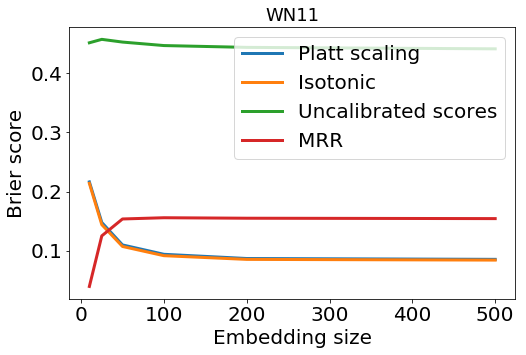

In [16]:
plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size': 20, 'axes.titlesize': 18})
plt.plot(df.k, df.brier_score_probas_pos_neg, lw=3, label="Platt scaling")
plt.plot(df.k, df.brier_score_probas_pos_neg_iso, lw=3, label="Isotonic")
plt.plot(df.k, df.brier_score_scores, lw=3, label="Uncalibrated scores")
plt.plot(df.k, df.metrics_mrr, lw=3, label="MRR")
plt.xlabel("Embedding size")
plt.ylabel("Brier score")
plt.legend()
plt.title("WN11")